# Installing libraries

In [2]:
# !pip3 install pandas numpy matplotlib scikit-learn openpyxl pyarrow


# Importing relevant libraries

In [3]:
import os
from pathlib import Path
from typing import Optional, Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_recall_fscore_support,
    classification_report, RocCurveDisplay
)

Matplotlib is building the font cache; this may take a moment.


# Reading from files

In [4]:
INPATH = Path("jobs.xlsx")
df = pd.read_excel(INPATH)

# Initial Checks

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time_of_post           9999 non-null   datetime64[ns]
 1   latitude               9999 non-null   float64       
 2   longitude              9999 non-null   float64       
 3   category               9999 non-null   int64         
 4   number_of_tradies      9999 non-null   int64         
 5   estimated_size         9999 non-null   object        
 6   number_of_impressions  9889 non-null   float64       
 7   accepted               9999 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 625.1+ KB


In [138]:
df.head()

,time_of_post,latitude,longitude,category,number_of_tradies,estimated_size,number_of_impressions,accepted
0,2019-09-15 11:40:06,-37.8994,144.9799,8,8376,medium,1004.0,0
1,2019-09-11 15:12:06,-37.8063,144.9964,3,5089,medium,772.0,0
2,2019-09-10 15:53:06,-37.8901,144.8885,7,3677,small,1103.0,0
3,2019-09-10 11:38:06,-33.7674,151.1690,3,9732,medium,1111.0,1
4,2019-09-10 17:38:06,-33.9091,151.2039,6,2476,small,360.0,0


In [139]:
print(f"Rows: {len(df):,}  Cols: {df.shape[1]}")


Rows: 9,999  Cols: 8


In [140]:
df.isna().sum()


time_of_post               0
latitude                   0
longitude                  0
category                   0
number_of_tradies          0
estimated_size             0
number_of_impressions    110
accepted                   0
dtype: int64

In [141]:
print("Duplicate rows:", int(df.duplicated().sum()))

Duplicate rows: 0


In [142]:
print(df.describe(include=[np.number]).T.round(3))

                        count      mean       std      min       25%  \
latitude               9999.0   -34.614     4.787  -38.222   -37.799   
longitude              9999.0   146.509     7.079  121.939   144.938   
category               9999.0     4.820     1.858    1.000     3.000   
number_of_tradies      9999.0  4225.785  3020.932  355.000  1627.000   
number_of_impressions  9889.0  1015.829   481.731 -745.000   689.000   
accepted               9999.0     0.264     0.441    0.000     0.000   

                            50%       75%        max  
latitude                -34.001   -33.842    -17.548  
longitude               145.139   151.206    151.543  
category                  5.000     6.000      9.000  
number_of_tradies      3677.000  7267.000  10000.000  
number_of_impressions  1007.000  1339.000   3245.000  
accepted                  0.000     1.000      1.000  


# DATA CLEANING

In [143]:
df.columns

Index(['time_of_post', 'latitude', 'longitude', 'category',
       'number_of_tradies', 'estimated_size', 'number_of_impressions',
       'accepted'],
      dtype='object')

In [144]:
df = df.copy()
df.columns = (
    df.columns.str.strip()
                .str.lower()
                .str.replace(r"\s+", "_", regex=True)
                .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
)

In [145]:
df['accepted'].unique()

array([0, 1])

In [146]:
print(df['time_of_post'].max(),df['time_of_post'].min())

2019-09-16 22:54:06 2019-09-10 00:01:06


In [147]:
df['number_of_impressions'].sort_values(ascending=True)


8483   -745.0
1495   -718.0
2031   -642.0
6064   -555.0
6820   -545.0
        ...  
9502      NaN
9517      NaN
9552      NaN
9653      NaN
9864      NaN
Name: number_of_impressions, Length: 9999, dtype: float64

In [148]:
df[df['number_of_impressions'] < 0] 

,time_of_post,latitude,longitude,category,number_of_tradies,estimated_size,number_of_impressions,accepted
70,2019-09-10 15:13:06,-33.7817,150.9731,6,2476,small,-141.0,0
80,2019-09-10 03:31:06,-34.0169,151.1989,3,9732,small,-47.0,0
180,2019-09-16 09:26:06,-37.8070,144.9205,5,1058,medium,-82.0,0
194,2019-09-13 11:41:06,-33.7773,151.2007,6,2476,small,-194.0,0
199,2019-09-14 10:04:06,-34.0689,151.4036,4,2257,small,-272.0,0
...,...,...,...,...,...,...,...,...
9432,2019-09-12 06:07:07,-37.8854,145.0974,6,8260,small,-261.0,0
9635,2019-09-10 07:19:07,-33.9684,151.2847,5,355,medium,-177.0,0
9722,2019-09-13 02:23:07,-33.8538,151.2839,8,1627,medium,-286.0,1
9841,2019-09-11 10:55:07,-37.8823,144.8478,6,8260,medium,-217.0,0


In [149]:
df[df['number_of_impressions'].isna()] 

,time_of_post,latitude,longitude,category,number_of_tradies,estimated_size,number_of_impressions,accepted
40,2019-09-13 17:45:06,-37.7495,145.0112,7,3677,medium,NaN,1
134,2019-09-13 09:48:06,-37.7390,145.0099,5,1058,medium,NaN,0
144,2019-09-15 10:08:06,-37.7601,144.9879,4,5479,small,NaN,0
170,2019-09-12 08:24:06,-33.8774,151.2550,6,2476,medium,NaN,0
274,2019-09-10 00:51:06,-33.8854,151.2861,5,355,small,NaN,0
...,...,...,...,...,...,...,...,...
9502,2019-09-16 12:36:07,-34.0215,151.1496,5,355,small,NaN,0
9517,2019-09-14 05:48:07,-34.0210,151.2193,2,7331,medium,NaN,0
9552,2019-09-10 16:04:07,-37.6989,144.9098,4,5479,medium,NaN,1
9653,2019-09-12 09:45:07,-37.8417,145.0211,4,5479,medium,NaN,0


In [150]:
df["estimated_size"].unique()

array(['medium', 'small'], dtype=object)

In [151]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Load the data from Excel file
df = pd.read_excel('jobs.xlsx')

# Display initial info
print(df.head())
print(df.info())
print(df.describe())

         time_of_post  latitude  longitude  category  number_of_tradies  \
0 2019-09-15 11:40:06  -37.8994   144.9799         8               8376   
1 2019-09-11 15:12:06  -37.8063   144.9964         3               5089   
2 2019-09-10 15:53:06  -37.8901   144.8885         7               3677   
3 2019-09-10 11:38:06  -33.7674   151.1690         3               9732   
4 2019-09-10 17:38:06  -33.9091   151.2039         6               2476   

  estimated_size  number_of_impressions  accepted  
0         medium                 1004.0         0  
1         medium                  772.0         0  
2          small                 1103.0         0  
3         medium                 1111.0         1  
4          small                  360.0         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time_of_

In [152]:


# Convert time_of_post to datetime
df['time_of_post_dt'] = df['time_of_post']

# Extract hour and day of week
df['hour'] = df['time_of_post_dt'].dt.hour
df['day_of_week'] = df['time_of_post_dt'].dt.dayofweek  # 0=Monday, 6=Sunday

# Handle missing values in number_of_impressions (impute with median)
df['number_of_impressions'] = df['number_of_impressions'].replace('', np.nan)  # If any empty strings
impressions_median = df['number_of_impressions'].median()
df['number_of_impressions'].fillna(impressions_median, inplace=True)

# Handle negative impressions (convert to absolute)
df['number_of_impressions'] = df['number_of_impressions'].abs()

# Encode estimated_size (assuming 'small' and 'medium')
le = LabelEncoder()
df['estimated_size_encoded'] = le.fit_transform(df['estimated_size'])


/var/folders/3r/fpswrq854tqd9qncc8s9jtkr0000gs/T/ipykernel_77329/1328992417.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['number_of_impressions'].fillna(impressions_median, inplace=True)


In [153]:

# Feature engineering: Region based on lat/lon
def get_region(lat, lon):
    if lat > -20 and lon > 120 and lon < 125:  # Broome approx
        return 'Broome'
    elif lat > -35 and lat < -32 and lon > 150:  # Sydney approx
        return 'Sydney'
    elif lat > -39 and lat < -36 and lon > 144 and lon < 146:  # Melbourne approx
        return 'Melbourne'
    else:
        return 'Other'

df['region'] = df.apply(lambda row: get_region(row['latitude'], row['longitude']), axis=1)

In [154]:


# Treat category as categorical
df['category'] = df['category'].astype('category')

# Check for duplicates and drop if any
df.drop_duplicates(inplace=True)

In [155]:
df['number_of_impressions'].max()

np.float64(3245.0)

In [156]:
df['number_of_impressions'].min()

np.float64(1.0)

In [157]:
# Descriptive statistics
print(df['accepted'].value_counts(normalize=True))  # Acceptance rate
print(df.groupby('region')['accepted'].mean())  # By region
print(df.groupby('estimated_size')['accepted'].mean())  # By size
print(df.groupby('hour')['accepted'].mean())  # By hour
print(df.groupby('category')['accepted'].mean())  # By category

accepted
0    0.736374
1    0.263626
Name: proportion, dtype: float64
region
Broome       0.338462
Melbourne    0.270468
Sydney       0.247212
Name: accepted, dtype: float64
estimated_size
medium    0.367251
small     0.163886
Name: accepted, dtype: float64
hour
0     0.079365
1     0.138728
2     0.090909
3     0.130252
4     0.086957
5     0.109661
6     0.115468
7     0.083333
8     0.107926
9     0.114074
10    0.111276
11    0.094708
12    0.410405
13    0.459581
14    0.408346
15    0.475610
16    0.380789
17    0.406926
18    0.401985
19    0.424837
20    0.450413
21    0.384956
22    0.464516
Name: accepted, dtype: float64
category
1    0.268293
2    0.235503
3    0.394775
4    0.261783
5    0.157172
6    0.299625
7    0.261253
8    0.252818
9    0.293023
Name: accepted, dtype: float64


/var/folders/3r/fpswrq854tqd9qncc8s9jtkr0000gs/T/ipykernel_77329/1814388085.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('category')['accepted'].mean())  # By category


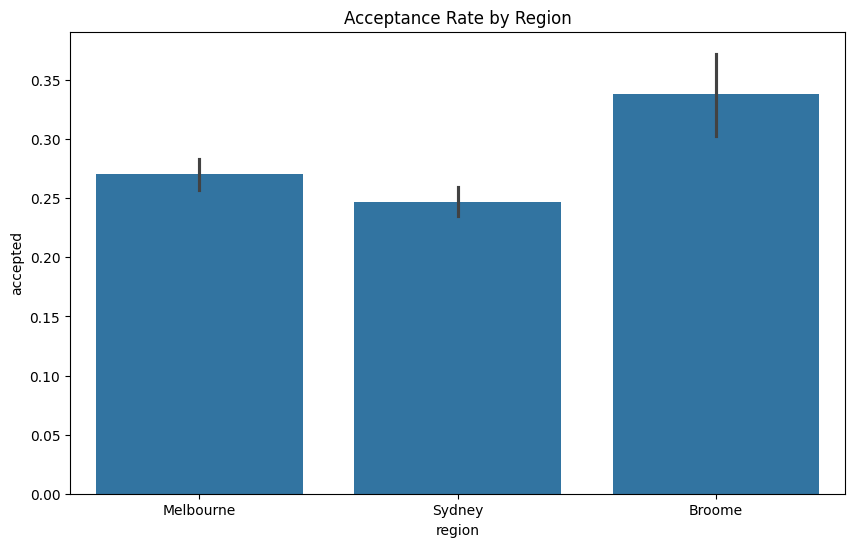

In [158]:


# Visualizations
# Acceptance by region
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='accepted', data=df)
plt.title('Acceptance Rate by Region')
plt.savefig('acceptance_by_region.png')

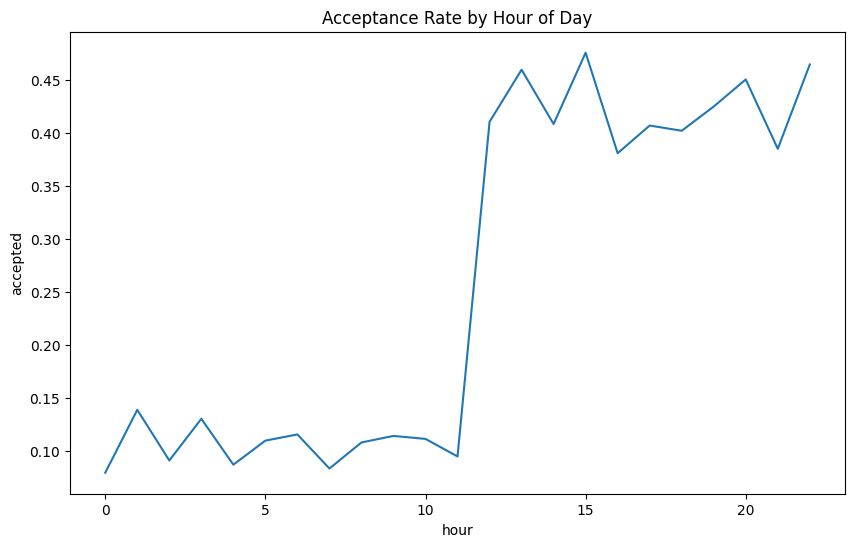

In [159]:
# Acceptance by hour
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='accepted', data=df.groupby('hour')['accepted'].mean().reset_index())
plt.title('Acceptance Rate by Hour of Day')
plt.savefig('acceptance_by_hour.png')

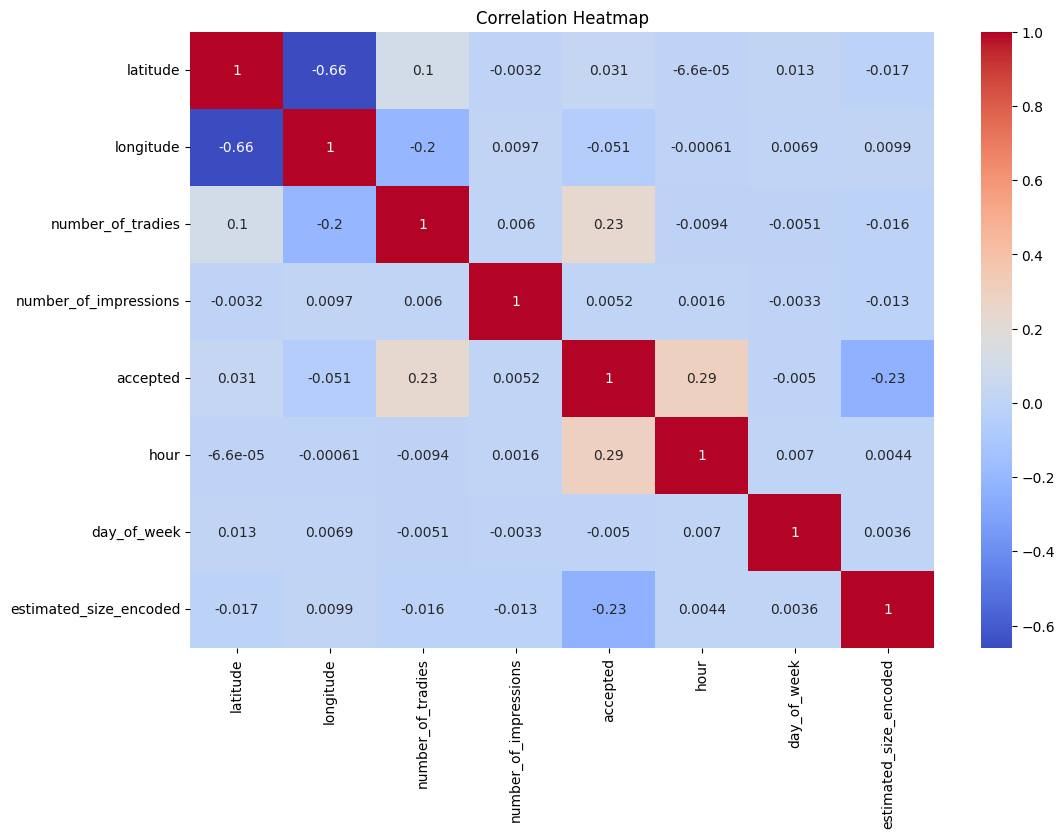

In [160]:
# Correlation heatmap (numeric features)
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')


In [161]:
# Feature scaling and encoding
numeric_features = ['latitude', 'longitude', 'number_of_tradies', 'number_of_impressions', 'hour', 'day_of_week']
categorical_features = ['category', 'estimated_size_encoded', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features) 
    ])

# Prepare for modeling
X = df[numeric_features + categorical_features]
y = df['accepted']

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Logistic Regression model with increased iterations and regularization
model = LogisticRegression(max_iter=1000, C=1.0, penalty='l2', solver='lbfgs')
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance (coefficients)
feature_names = (numeric_features + 
                 preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist())
coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': model.coef_[0]})
print(coefficients.sort_values('Coefficient', ascending=False))

Accuracy: 0.773
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1474
           1       0.62      0.35      0.45       526

    accuracy                           0.77      2000
   macro avg       0.71      0.64      0.65      2000
weighted avg       0.75      0.77      0.75      2000

                     Feature  Coefficient
4                       hour     0.837164
2          number_of_tradies     0.632169
8                 category_4     0.033154
7                 category_3     0.028864
1                  longitude     0.026042
11                category_7     0.019759
0                   latitude    -0.011216
3      number_of_impressions    -0.012425
5                day_of_week    -0.015894
9                 category_5    -0.024661
10                category_6    -0.038596
6                 category_2    -0.063845
15          region_Melbourne    -0.192963
12                category_8    -0.198508
16             region_Sydne

/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * 

In [162]:
# Feature scaling and encoding
numeric_features = ['number_of_tradies', 'number_of_impressions', 'hour', 'day_of_week']
categorical_features = ['category', 'estimated_size_encoded', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features) 
    ])

# Prepare for modeling
X = df[numeric_features + categorical_features]
y = df['accepted']

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Logistic Regression model with increased iterations and regularization
model = LogisticRegression(max_iter=1000, C=1.0, penalty='l2', solver='lbfgs')
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance (coefficients)
feature_names = (numeric_features + 
                 preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist())
coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': model.coef_[0]})
print(coefficients.sort_values('Coefficient', ascending=False))

Accuracy: 0.772
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1474
           1       0.62      0.35      0.44       526

    accuracy                           0.77      2000
   macro avg       0.71      0.64      0.65      2000
weighted avg       0.75      0.77      0.75      2000

                     Feature  Coefficient
2                       hour     0.837013
0          number_of_tradies     0.631889
5                 category_3     0.018828
6                 category_4     0.017824
9                 category_7     0.009680
1      number_of_impressions    -0.012600
3                day_of_week    -0.016068
7                 category_5    -0.034107
8                 category_6    -0.050763
13          region_Melbourne    -0.064229
14             region_Sydney    -0.072922
4                 category_2    -0.079273
10                category_8    -0.207421
11                category_9    -0.251774
12  estimated_size_encoded_

/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * 

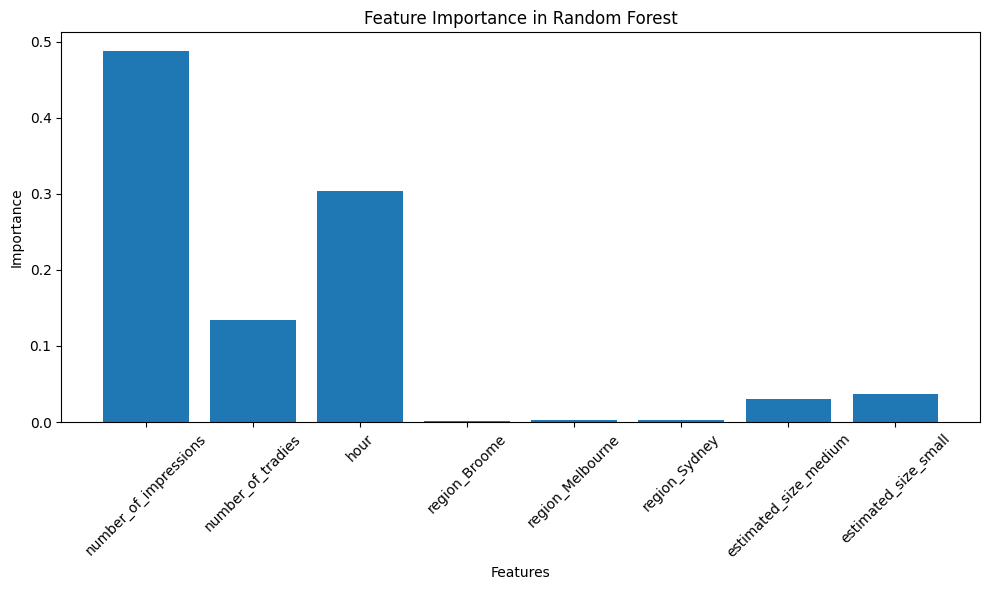

In [165]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Assuming this is your preprocessing
X = pd.get_dummies(df[['region', 'estimated_size', 'number_of_impressions', 'number_of_tradies', 'hour']])
y = df['accepted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = X_train.values  # Convert to NumPy array for training
X_test = X_test.values

# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Use the column names from the original DataFrame X
feature_names = X.columns  # This retains the encoded column names

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances, align='center')
plt.xticks(range(len(importances)), feature_names, rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.tight_layout()
plt.show()